In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import os
import matplotlib.colors as mcolors
import pickle

from ipynb.fs.full.functions_for_creating_plots import *
os.chdir(os.getcwd())

In [29]:
## Dictionary holding the numbers of the molecules in the model (for explanation, look up model-figure.pdf)
molecules_dict={'$\mathbf{G_{GTP}}$':[23,33],
                '$\mathbf{IP_{3}}$':[40],
                'Total Arrestin-Receptor':[10,11,12,13,14,15],
                'PM Arrestin-Receptor':[10,11,12],
                'IC Arrestin-Receptor':[13,14,15]}

## Determine ligand concentrations              
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
internalisation_status=['With_internalisation','No_internalisation']

## Simulation time
simulation_time=1200


subplot_layout=[['.','B','C','D'],
                ['E_up','F_up','G_up','H_up'],
                ['E_low','F_low','G_low','H_low'],
                ['I','J','K','K'],
                ['L','L','M','M']]


### Add plots for the first row (subplots **B - D**)
#### To be able to add additional subplots to the subplots_mosaic object later, plt.show() mustn't run plt.show() function and close the figure.
#### -> To prevent this plt.ioff() is run, but somehow it only takes effect after running this cell at least 2 times
## !!!! If running this script from scratch, run this cell 2 times, so subplots_mosaic object can be updated later with additional subplots!!!!!


In [30]:
def draw_kinetic_concentration_curve_of_molecule_with_different_ligand_ccs(molecule,molecules_dict,kon,koff,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator):
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    # Extract the maximum value of receptor-arrestin concentrations, in order to determine the common Y-axis range for the plots E-H
    arrestin_receptor_max_response=0
    
    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file with only columns that contain data 
    #  for the molecule to be plotted
    for ligand,color in zip(ligands,colors):
        fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
        col_nums=[int(x+1) for x in molecules_dict[molecule]]
        col_nums.append(0)
        mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
        plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=ligand,color=color)
        ## Extract the maximum value of Arrestin-Receptor curves 
        if molecule=='Total Arrestin-Receptor' and max(np.sum(mol_ccs_df.loc[:,:],1))>arrestin_receptor_max_response:
            arrestin_receptor_max_response=max(np.sum(mol_ccs_df.loc[:,:],1))

    
    ## Customize legend, plot title, axis labels 
    plot_area=fig_width*fig_height

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title="$\mathbf{Low\ K_{off}}$"
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)

    return plot,arrestin_receptor_max_response

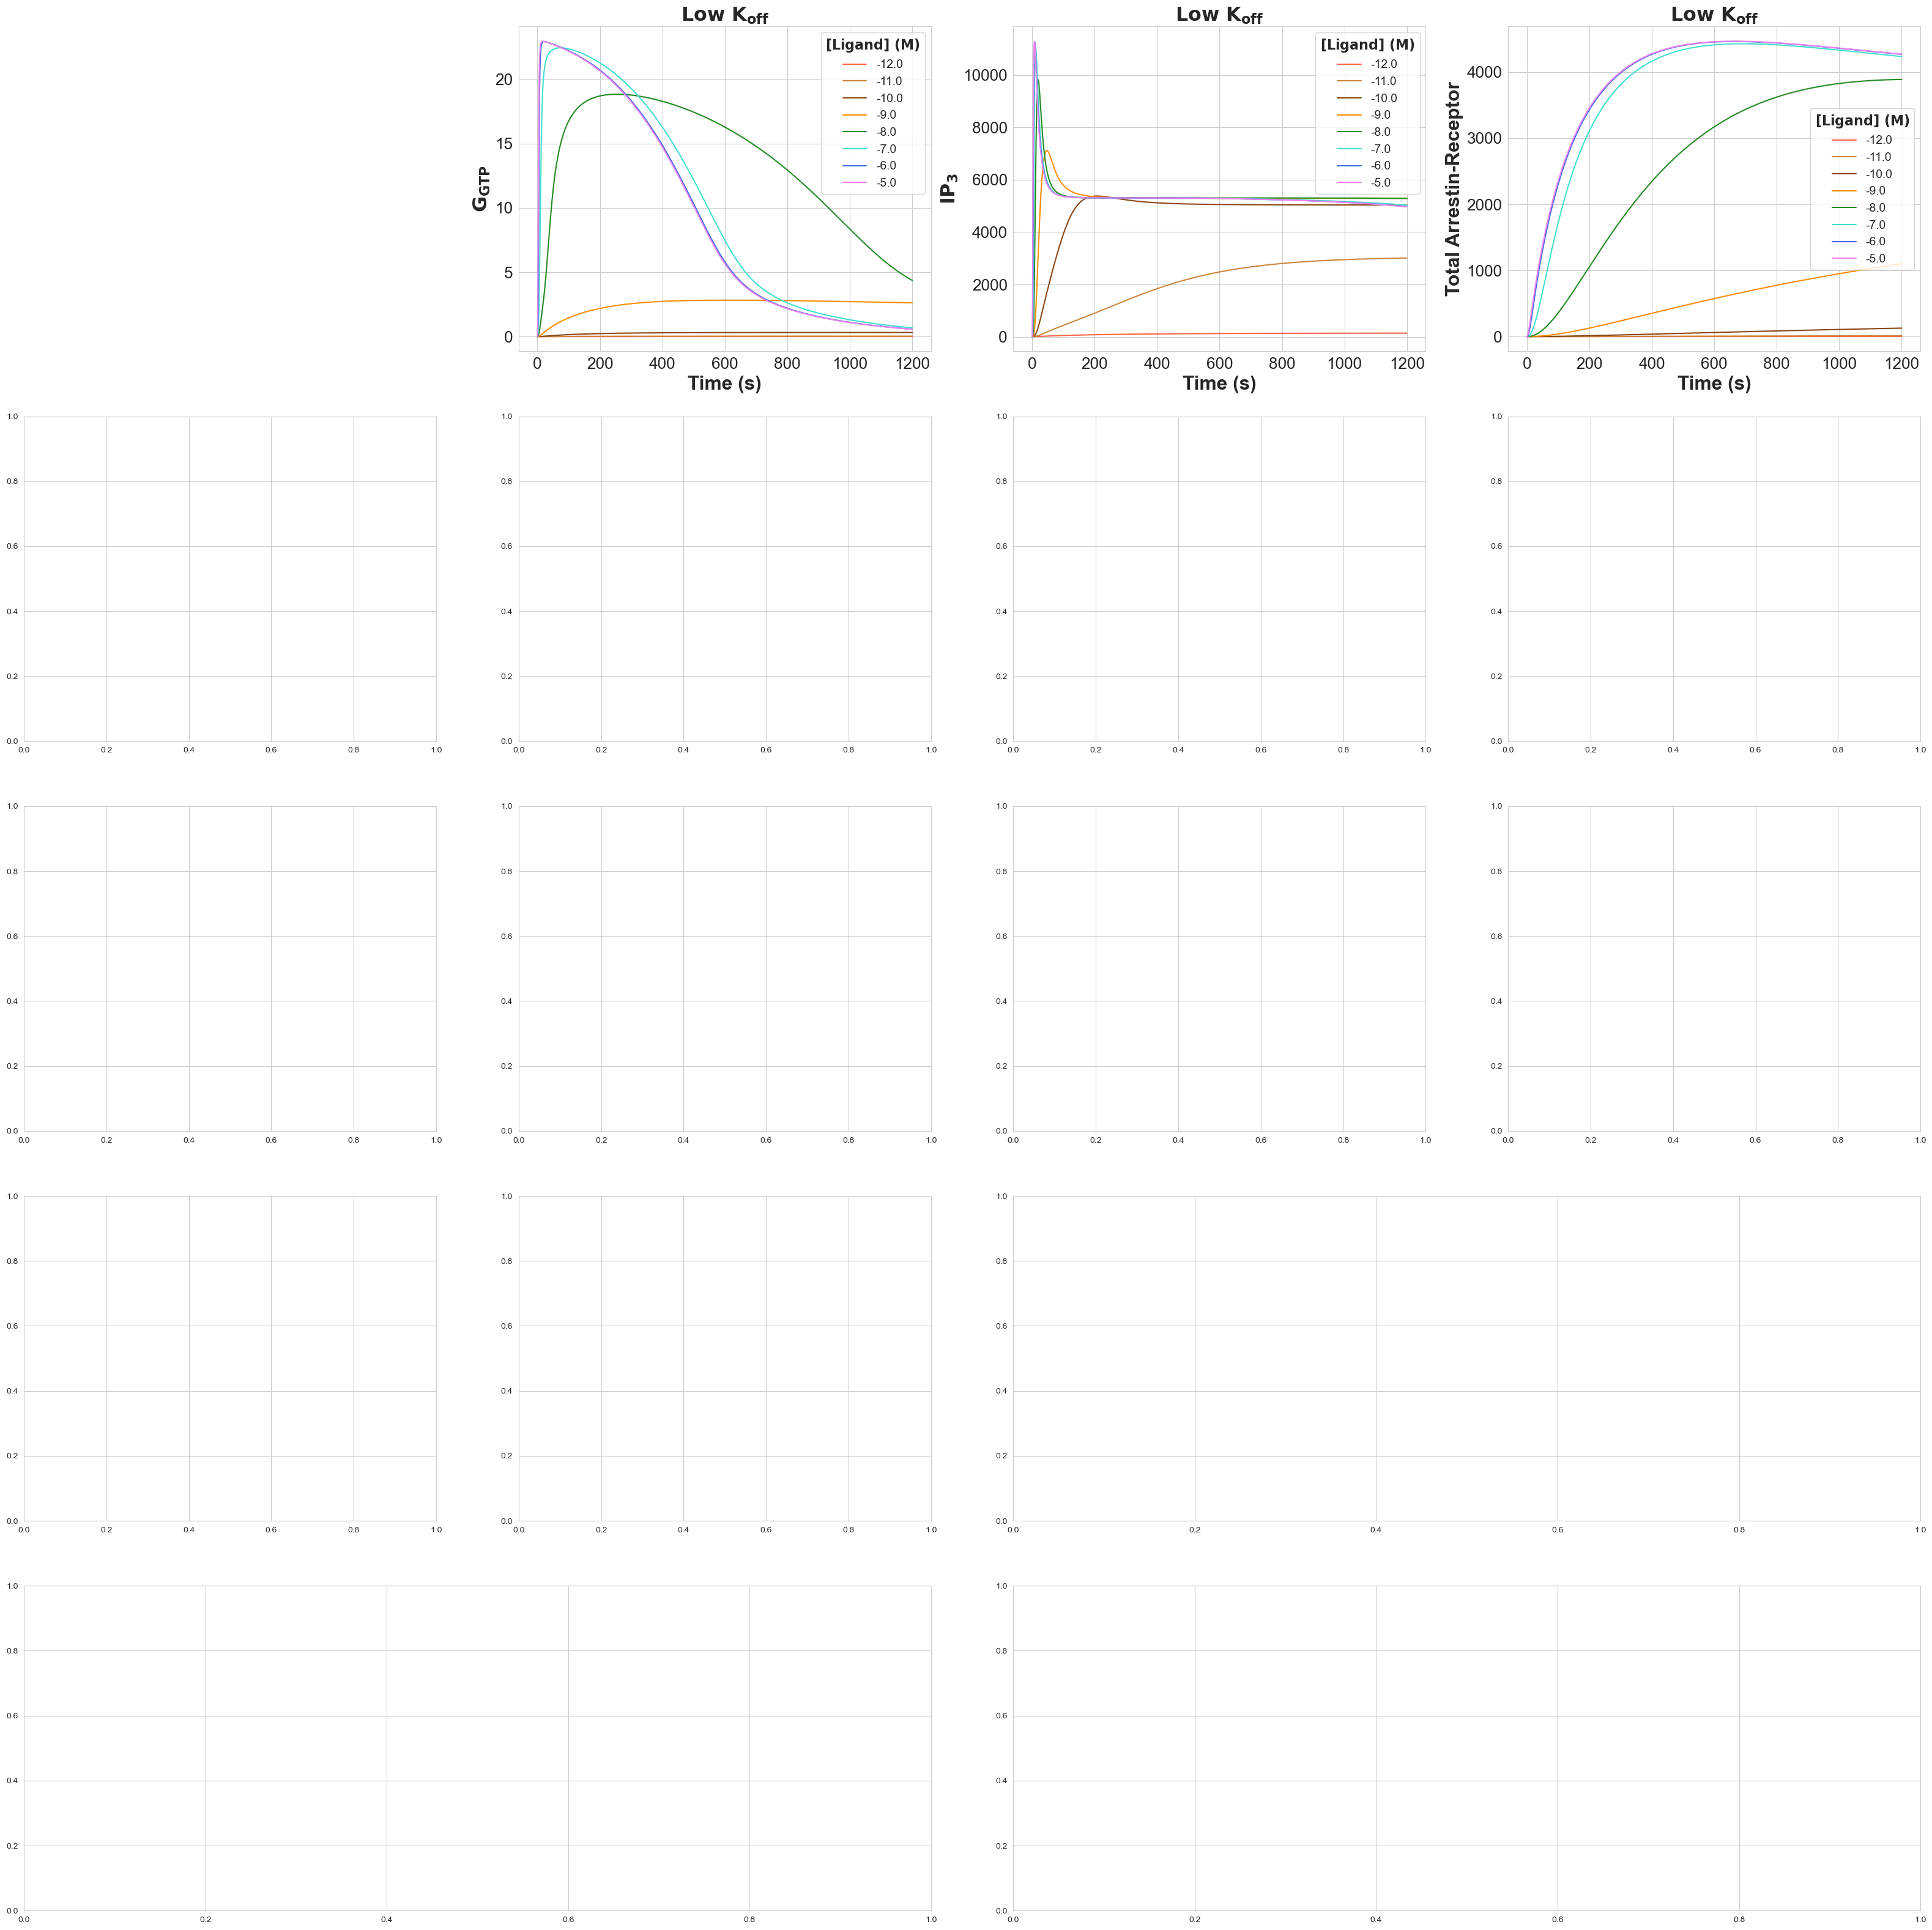

In [36]:
## Define subplots and molecules to plot
subplots_names=['B','C','D']
molecules_to_plot=['$\mathbf{G_{GTP}}$','$\mathbf{IP_{3}}$','Total Arrestin-Receptor']

## Define the parameters for the plots
kon=0.3
koff=0.0003
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
intern_status='With_internalisation'
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']


subplot_layout=[['.','B','C','D'],
                ['E_up','F_up','G_up','H_up'],
                ['E_low','F_low','G_low','H_low'],
                ['I','J','K','K'],
                ['L','L','M','M']]
fig_width=40
fig_height=40

fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))


## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=115
legend_title='$\mathbf{[Ligand]\ (M)}$'
subplot_legend_title_fontsize_nominator=100



for subplot_name,molecule in zip(subplots_names,molecules_to_plot):
    ax[subplot_name],arrestin_receptor_max_response=draw_kinetic_concentration_curve_of_molecule_with_different_ligand_ccs(molecule,molecules_dict,kon,koff,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator)
    if molecule=='Total Arrestin-Receptor':
        with open('../data/arrestin_receptor_max_response.pkl','wb') as file:
            pickle.dump(arrestin_receptor_max_response,file)


        
## Save fig and axes object for later to add more subplots to it
with open('../data/temporary_plot_B_D_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temporary_plot_B_D_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)



### Add plots for the second and third row (**E - G**)

In [32]:
def draw_kinetic_concentration_curve_of_molecule_with_different_koff_values(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,legend_handles,ylim):
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for koff,color,label in zip(koff_list,colors,legend_handles):
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        label=label + str(koff)
        for ligand in ligands:
            fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
            col_nums=[int(x+1) for x in molecules_dict[molecule]]
            col_nums.append(0)
            mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
            plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color)
    
    ## Customize legend, plot title, axis labels 
    plot_area=fig_width*fig_height

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title=r"$\mathbf{{title}}$".replace('title',title_text)
 
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    return(plot)

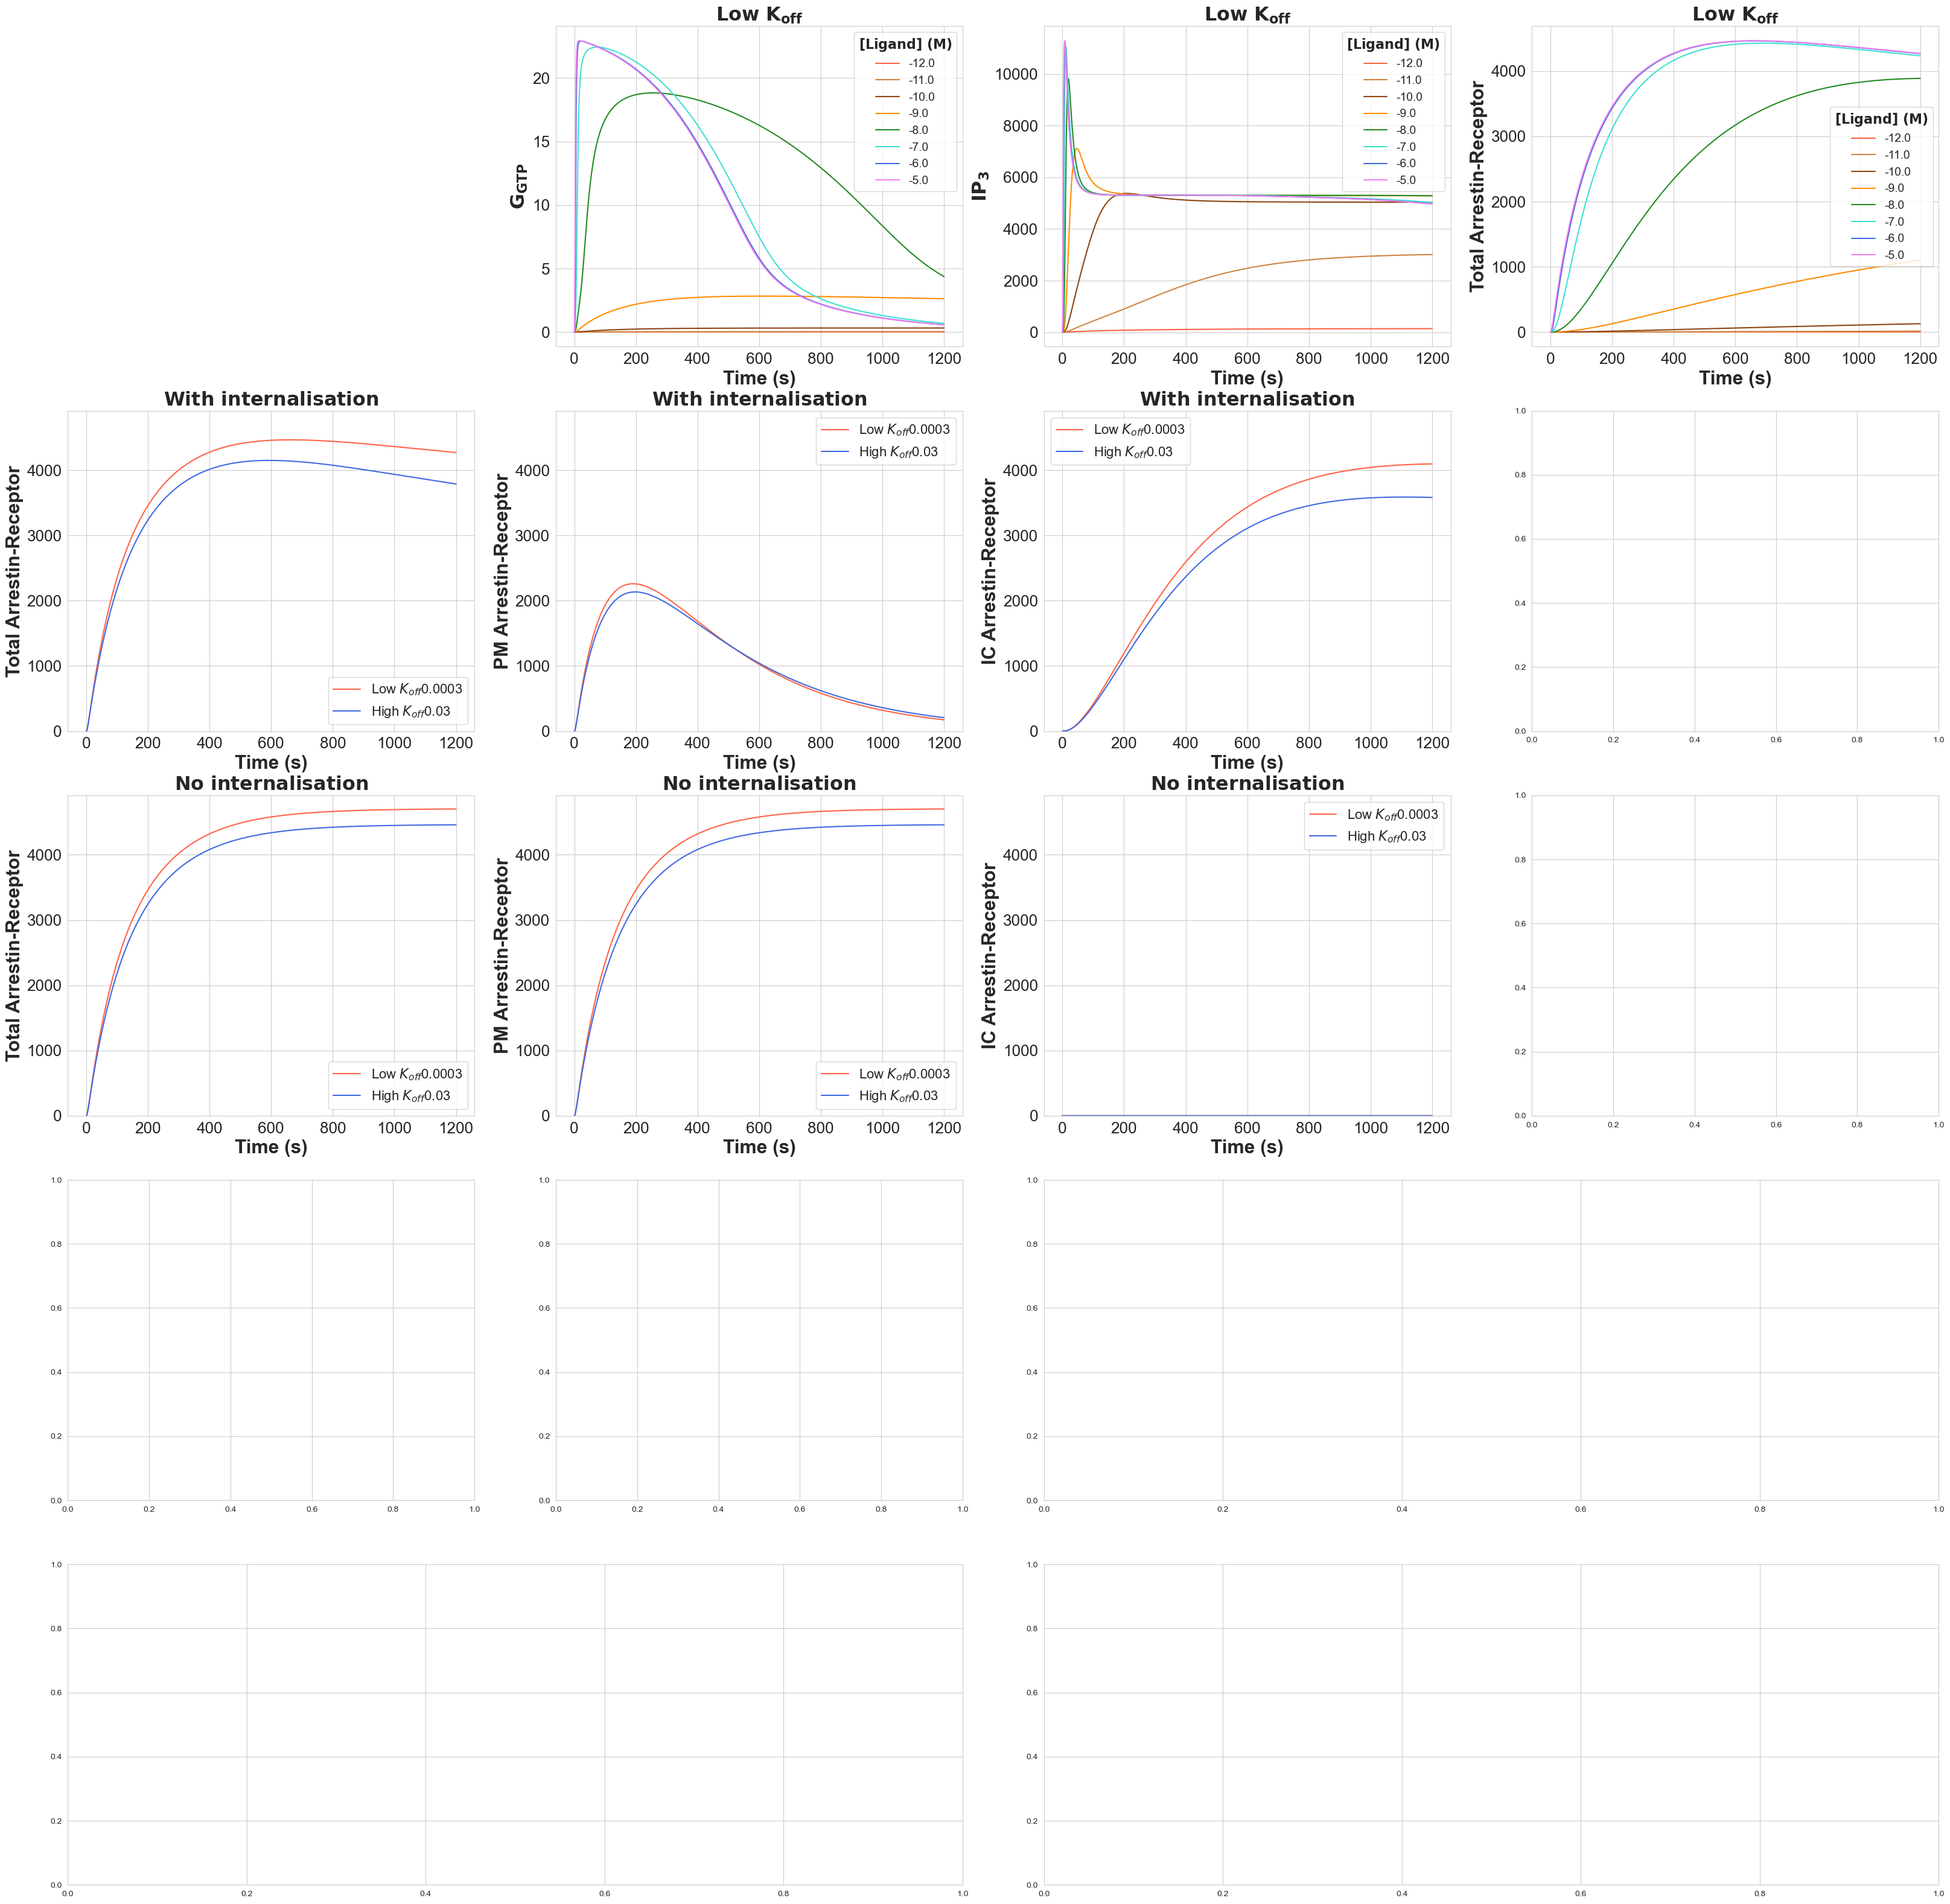

In [38]:
subplots_names=[['E_up','F_up','G_up'],
                ['E_low','F_low','G_low']]
molecules_to_plot=['Total Arrestin-Receptor','PM Arrestin-Receptor','IC Arrestin-Receptor']

kon=0.3
koff_list=[0.0003,0.03]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','royalblue']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(1, 1.1, 1))

fig_width=40
fig_height=40

#fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
#legend_title='$\mathbf{K_{off}}$'
legend_title=None
legend_handles=['Low $K_{off}$','High $K_{off}$']

### Load the previosly ceated figur and axes object to plot to
with open('../data/temporary_plot_B_D_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temporary_plot_B_D_axes_object.pkl','rb') as file:
    ax=pickle.load(file)
with open('../data/arrestin_receptor_max_response.pkl','rb') as file:
    arrestin_receptor_max_response=pickle.load(file)

## Set common y-axis limit for all the plots in E-H
ylim=arrestin_receptor_max_response*1.1

for molecule,colnum in zip(molecules_to_plot,range(np.asarray(subplots_names).shape[1])):
    for intern_status,rownum in zip(internalisation_status,range(np.asarray(subplots_names).shape[0])):
        subplot_name=subplots_names[rownum][colnum]
        ax[subplot_name]=draw_kinetic_concentration_curve_of_molecule_with_different_koff_values(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,legend_handles,ylim)

## Save fig and axes object for later to add more subplots to it
with open('../data/temporary_plot_B_G_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temporary_plot_B_G_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)

In [34]:
def draw_DR_points_plus_fit_DR_curve(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                    color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                    subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                    subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                    legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim):
    
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    
    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for koff,color,label in zip(koff_list,colors,legend_handles):
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
        DR_points=[]
        label=label + str(koff)

        for ligand in ligands:
            fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
            col_nums=[int(x+1) for x in molecules_dict[molecule]]
            col_nums.append(0)
            mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
            response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
            DR_points.append(response_at_time)
        
        ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for plotting the fitted DR curve
        def func(ligands, logec50):
            return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
        logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

        ## Create x-axis values for DR curve
        ligandrange = np.linspace(ligands[0], ligands[-1], 100)
        axis.plot((ligandrange), func(10 ** ligandrange, logec50), color=color)
        axis.plot(ligands, DR_points, '.',label=label, color=color)
        
        
    #plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color)
    
    ## Customize legend, plot title, axis labels 
    plot_area=fig_width*fig_height

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title=r"$\mathbf{{title}}$".replace('title',title_text)
 
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    return(axis)

### Add 2 DR-curve plots (__H__)

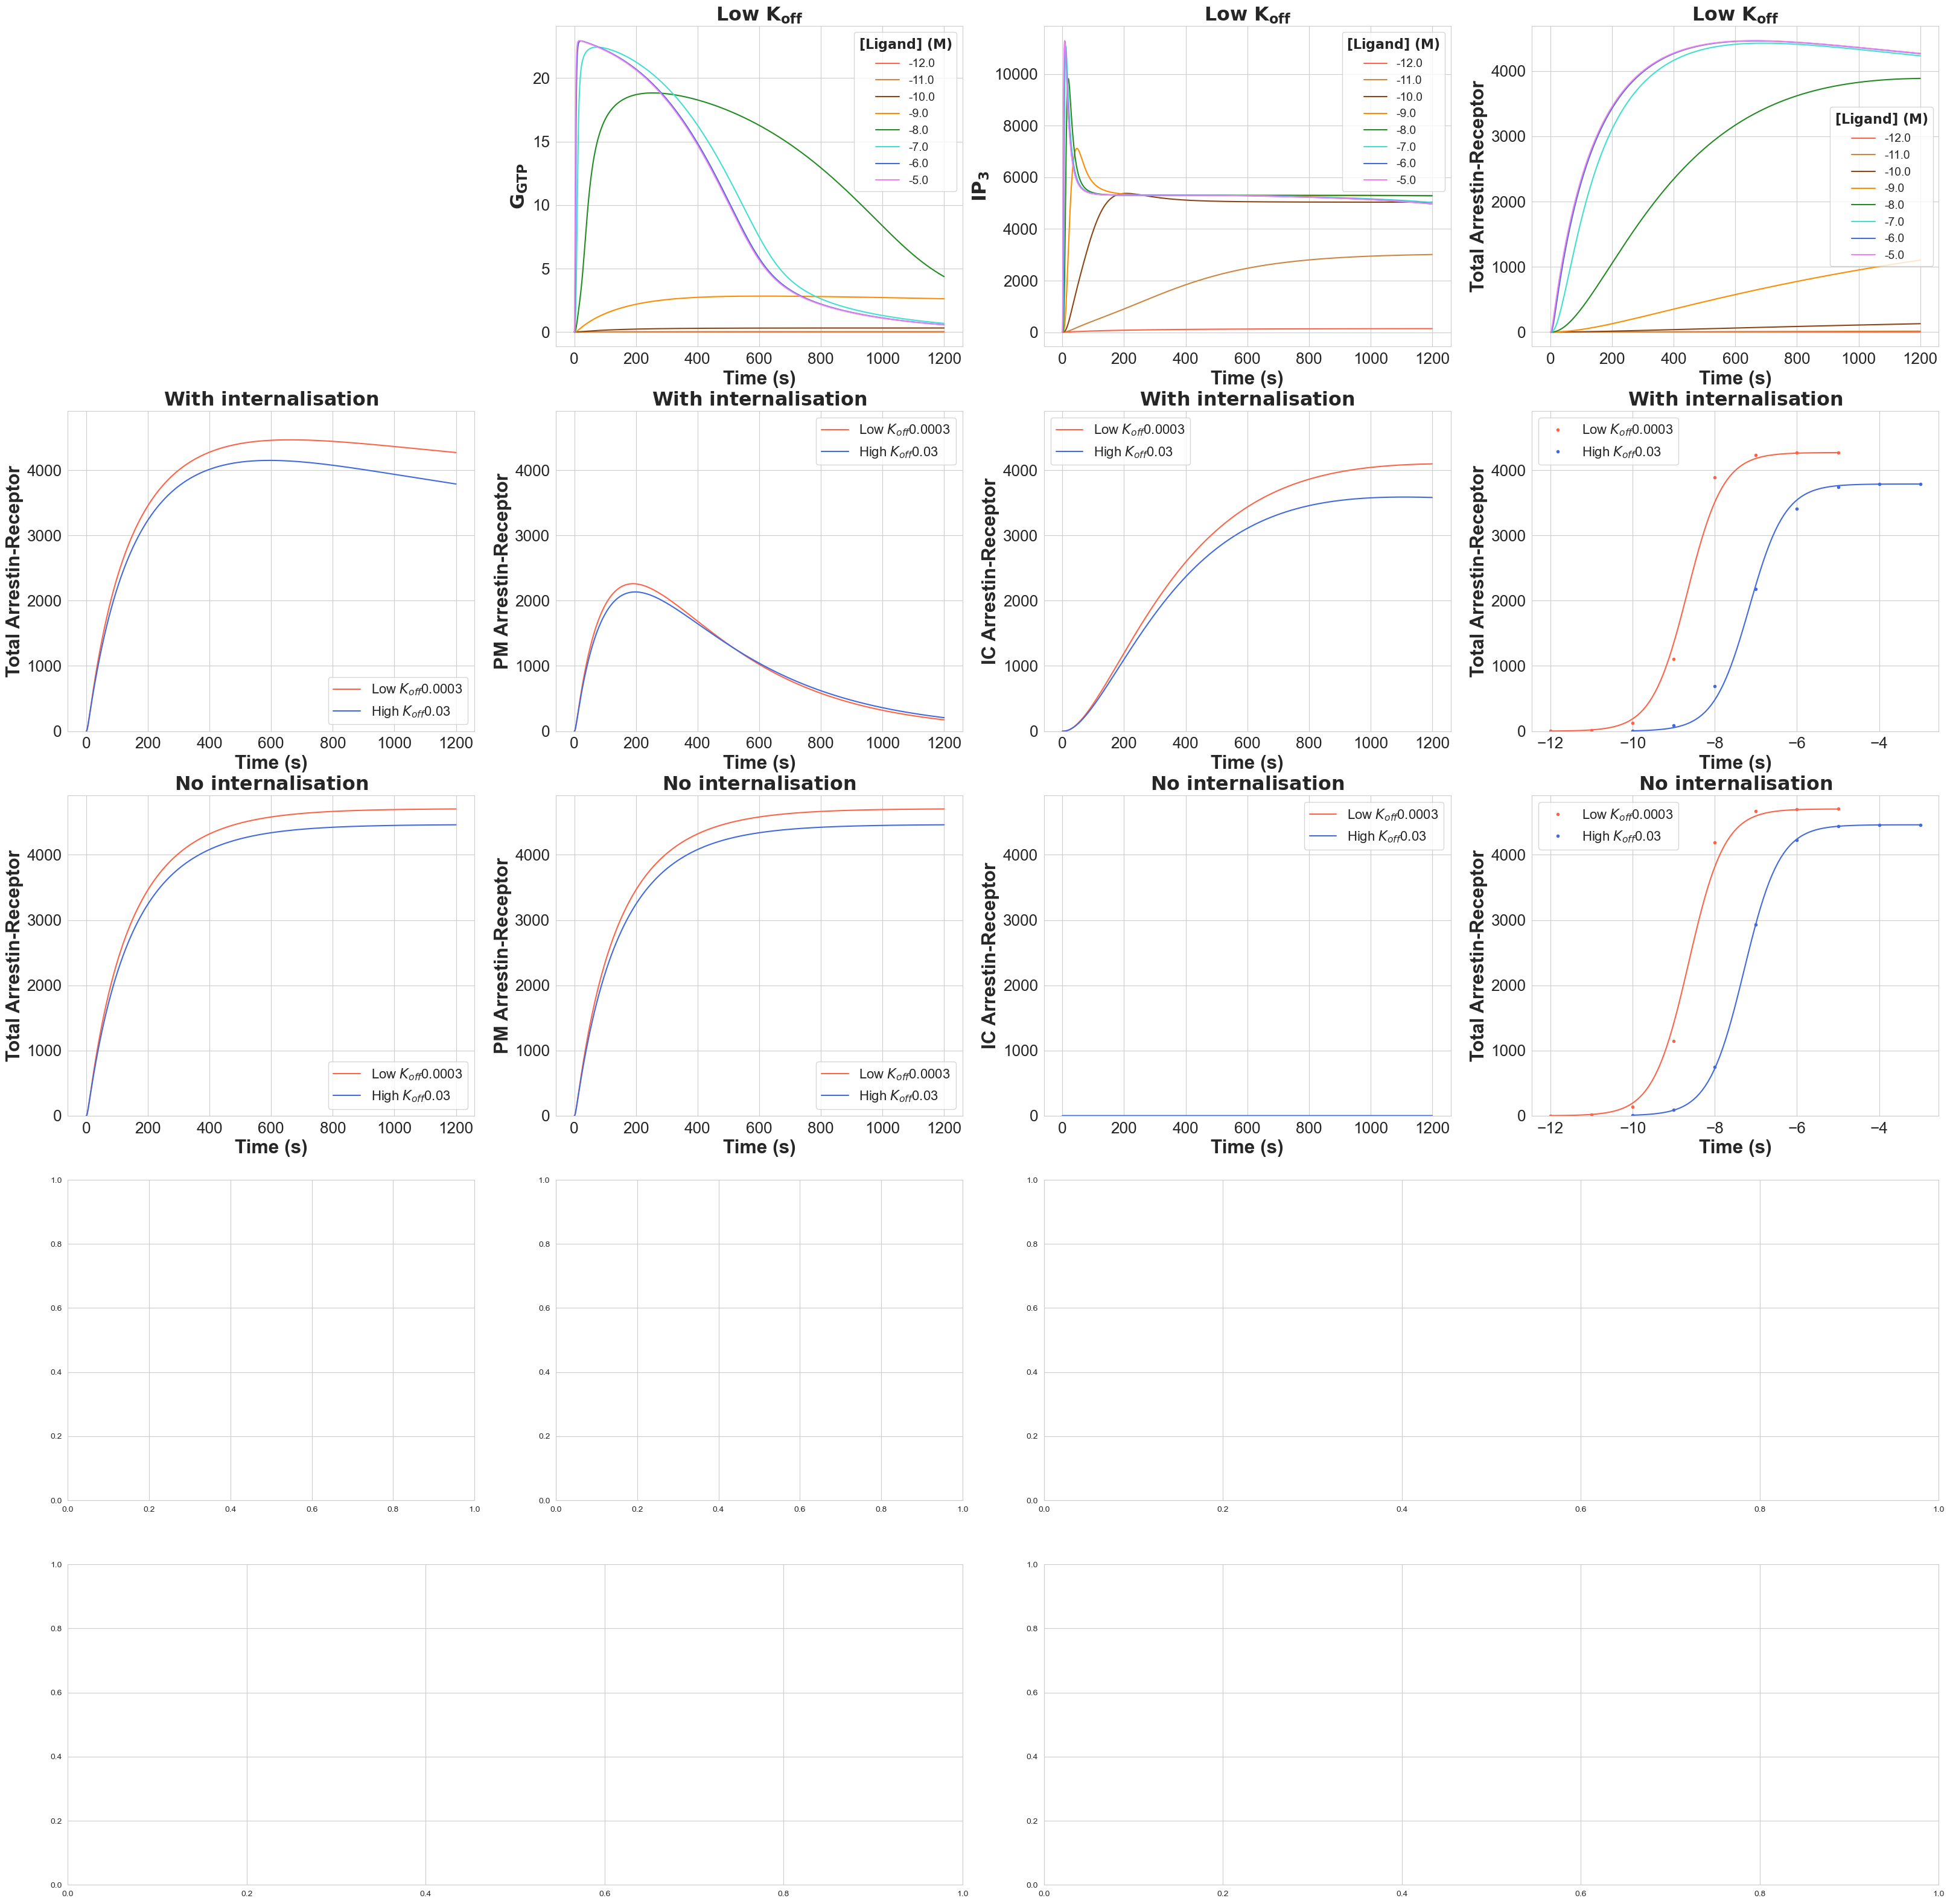

In [39]:
subplots_names=[['H_up'],['H_low']]
molecules_to_plot=['Total Arrestin-Receptor']

### Load the previosly ceated figur and axes object to plot to
with open('../data/temporary_plot_B_G_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temporary_plot_B_G_axes_object.pkl','rb') as file:
    ax=pickle.load(file)
with open('../data/arrestin_receptor_max_response.pkl','rb') as file:
    arrestin_receptor_max_response=pickle.load(file)

## Set common y-axis limit for all the plots in E-H
ylim=arrestin_receptor_max_response*1.1
time_to_response=1200

kon=0.3
koff_list=[0.0003,0.03]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','royalblue']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

#fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
#legend_title='$\mathbf{K_{off}}$'
legend_title=None
legend_handles=['Low $K_{off}$','High $K_{off}$']



for molecule,colnum in zip(molecules_to_plot,range(np.asarray(subplots_names).shape[1])):
    for intern_status,rownum in zip(internalisation_status,range(np.asarray(subplots_names).shape[0])):
        subplot_name=subplots_names[rownum][colnum]
        ax[subplot_name]=draw_DR_points_plus_fit_DR_curve(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                    color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                    subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                    subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                    legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim)

## Save fig and axes object for later to add more subplots to it
with open('../data/temporary_plot_B_H_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temporary_plot_B_H_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)


In [ ]:
kon=0.3
process_name='Koff_Kon_all'
dirname='../data/With_internalisation/Koff_Kon_all/'
import matplotlib.colors as mcolors

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
fig,ax=plt.subplots(1,3,figsize=(17.5,6.25))
fig2,ax2=plt.subplots(1,3,figsize=(17.5,6.25))
for n,koff in enumerate([0.0003,0.03,0.3]):
    
    Kd_ratio = (koff/ kon) / (0.0003 / 0.3)
    ligands = ligand_ccs * Kd_ratio
    ligands=(np.log10(ligands) - 6)
    colors=[*mcolors.XKCD_COLORS][25:25+len(ligands)]
    for ligand,color in zip(ligands,colors):
        fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
        col_nums=[int(x+1) for x in molecules_dict['Arrestin-Receptor']]
        col_nums.append(0)
        arr_receptor_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
        ax[n].plot(arr_receptor_df.index.tolist(),np.sum(arr_receptor_df.loc[:,:],1),label=ligand,color=mcolors.XKCD_COLORS[color])
        ax2[n].scatter(ligand,np.sum(arr_receptor_df.iloc[-1,:]),label=ligand,color=mcolors.XKCD_COLORS[color])
    ax[n].legend()
    title=' '.join(['Koff',str(koff),'Kon:',str(kon)])
    ax[n].set_title(title)
    ax[n].set_xlabel('Time (s)',fontweight="bold")
    ax[n].set_ylabel('Arrestin-Receptor',fontweight="bold",fontsize=11)
    ax[n].set_ylim(0,4500)
    ax2[n].legend(ligands)
    ax2[n].set_title(title)
    ax2[n].set_xlabel('log10 Ligand [mol/l]',fontweight="bold")
    ax2[n].set_ylabel('Arrestin-Receptor at '+str(int(arr_receptor_df.index.tolist()[-1])) +' sec',fontweight="bold",fontsize=11)
    ax2[n].set_ylim(-50,4500)
fig.savefig('../data/control_figs/plot2.png',dpi=300)
fig2.savefig('../data/control_figs/plot3.png',dpi=300)